When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Load Wikipedia dataset

We will be using the dataset of abridged Wikipedia pages. Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [2]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


If you want to check whether the text on the webpage agrees with the one here, you can display it with the following code:

In [3]:
# from IPython.display import HTML
# print(wiki['text'][0])
# HTML(url=wiki['URI'][0]

## Ex. 1: Extract word count vectors

As we have seen in Assignment 4, we can extract word count vectors using `CountVectorizer` function.
- make sure you include words of unit length by using the parameter: `token_pattern=r"(?u)\b\w+\b"`
- do not use any stopwords
- take 10000 most frequent words in the corpus
- explicitly take all the words independent of in how many documents they occur
- obtain the matrix of word counts

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with the specified parameters
vectorizer = CountVectorizer(
    token_pattern=r"(?u)\b\w+\b",  # Include words of unit length
    max_features=10000,           # Take 10,000 most frequent words
    stop_words=None,              # Do not use any stopwords
    min_df=1                      # Include all words regardless of document frequency
)

# Obtain the matrix of word counts
WCmatrix = vectorizer.fit_transform(wiki['text'])

# Inspect the shape of the resulting word count matrix
print(f"Word Count Matrix Shape: {WCmatrix.shape}")

Word Count Matrix Shape: (59071, 10000)


## Ex. 2: Find nearest neighbors

**a)** Start by finding the nearest neighbors of the Barack Obama page using the above word count matrix to represent the articles and **Euclidean** distance to measure distance.
Save the distances in `wiki['BO-eucl']` and look at the top 10 nearest neighbors.

In [5]:
# One can use the following:
    # from sklearn.neighbors import NearestNeighbors
    # nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute',metric='euclidean').fit(X.toarray())
    # distances, indices = nbrs.kneighbors(X.toarray())
# but here let's use:
from sklearn.metrics import pairwise_distances

# Locate the index of "Barack Obama"
obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]

# Extract the vector for "Barack Obama"
obama_vector = WCmatrix[obama_index] # above matrix

# Compute distances only between "Barack Obama" and all other articles, with Eucledian distance as the metric
dist = pairwise_distances(obama_vector, WCmatrix, metric='euclidean').flatten()

# Add the distances to the dataset
wiki['BO-eucl'] = dist

# Find the top 10 nearest neighbors (excluding "Barack Obama" itself)
top_neighbors = wiki.nsmallest(11, 'BO-eucl')[1:]  # Exclude the first as it is "Barack Obama"

# Display the top 10 nearest neighbors
print(top_neighbors[['name', 'BO-eucl']])


                             name    BO-eucl
24478                   Joe Biden  31.336879
28447              George W. Bush  33.645208
48202                Tony Vaccaro  33.734256
14754                 Mitt Romney  34.351128
31423              Walter Mondale  34.423829
36364                  Don Bonker  34.597688
13229            Francisco Barrio  34.669872
35357            Lawrence Summers  35.383612
25258           Marc Ravalomanana  35.440090
22745  Wynn Normington Hugh-Jones  35.454196


**b)** Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [6]:
# Extract indices for the three individuals
obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]
bush_index = wiki[wiki['name'] == 'George W. Bush'].index[0]
biden_index = wiki[wiki['name'] == 'Joe Biden'].index[0]

# Extract the word count vectors for each individual
obama_vector = WCmatrix[obama_index]
bush_vector = WCmatrix[bush_index]
biden_vector = WCmatrix[biden_index]

# Compute pairwise distances between the vectors
dist_obama_bush = pairwise_distances(obama_vector, bush_vector, metric='euclidean')[0][0]
dist_obama_biden = pairwise_distances(obama_vector, biden_vector, metric='euclidean')[0][0]
dist_bush_biden = pairwise_distances(bush_vector, biden_vector, metric='euclidean')[0][0]

# Display the distances
print(f"Distance between Barack Obama and George W. Bush: {dist_obama_bush}")
print(f"Distance between Barack Obama and Joe Biden: {dist_obama_biden}")
print(f"Distance between George W. Bush and Joe Biden: {dist_bush_biden}")

# Identify the pair with the smallest distance
min_distance = min(dist_obama_bush, dist_obama_biden, dist_bush_biden)
if min_distance == dist_obama_bush:
    closest_pair = "Barack Obama and George W. Bush"
elif min_distance == dist_obama_biden:
    closest_pair = "Barack Obama and Joe Biden"
else:
    closest_pair = "George W. Bush and Joe Biden"

print(f"The closest pair is: {closest_pair} with a distance of {min_distance}")


Distance between Barack Obama and George W. Bush: 33.645207682521445
Distance between Barack Obama and Joe Biden: 31.336879231984796
Distance between George W. Bush and Joe Biden: 30.919249667480614
The closest pair is: George W. Bush and Joe Biden with a distance of 30.919249667480614


All of the 10 people from **a)** are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians, e.g.,

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

**c)** Let's find out why Francisco Barrio was considered a close neighbor of Obama.
To do this, look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

In [7]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's Wikipedia page.
    """
    # Locate the index of the given person's page
    person_index = wiki[wiki['name'] == name].index[0]
    
    # Extract the word count vector for the person
    person_vector = WCmatrix[person_index]
    
    # Get the vocabulary (mapping of words to column indices)
    vocab = vectorizer.get_feature_names_out()
    
    # Convert the sparse matrix to a dense array
    word_counts = person_vector.toarray().flatten()
    
    # Create a DataFrame of words and their counts
    df = pd.DataFrame({'word': vocab, 'count': word_counts})
    
    # Sort by count in descending order
    return df.sort_values(by='count', ascending=False)

# Get the top words for Barack Obama and Francisco Barrio
obama_words = top_words('Barack Obama')
barrio_words = top_words('Francisco Barrio')

# Display the top 10 words for each
print("Top words for Barack Obama:")
print(obama_words.head(10))

print("\nTop words for Francisco Barrio:")
print(barrio_words.head(10))


Top words for Barack Obama:
       word  count
9063    the     40
4616     in     30
722     and     21
6378     of     18
9162     to     14
4387    his     11
6342  obama      9
453     act      8
4284     he      7
372       a      7

Top words for Francisco Barrio:
          word  count
9063       the     36
6378        of     24
722        and     18
4616        in     17
4284        he     10
9162        to      9
4086  governor      6
372          a      6
4387       his      5
903         as      5


Most of the top words for both Barack Obama and Francisco Barrio are common function words like "the," "of," "and," "in," and "to." These words do not carry significant meaning by themselves, which is typical in most text analyses. However, a few key terms stand out - "act" and "obama" in Obama's case, and "governor" in Barrio's. This suggests that while the texts primarily rely on general language, the specific terms highlight the core themes or roles associated with each figure. "Act" can refer to significant legislation in Obama´s presidency, while "obama" highlights his personal legacy. "Governor" focuses on Barrio's political role, suggesting the text centers around his leadership and regional impact.

**d)** Extract the list of most frequent **common** words that appear in both Obama's and Barrio's documents and display the five words that appear most often in Barrio's article.

Use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the index column of words). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

In [8]:
# Extract top words for Barack Obama and Francisco Barrio
obama_words = top_words('Barack Obama').set_index('word')
barrio_words = top_words('Francisco Barrio').set_index('word')

# Join the two DataFrames on the 'word' index
common_words = obama_words.join(barrio_words, how='inner', lsuffix='_Obama', rsuffix='_Barrio')

# Sort by the word frequency in Francisco Barrio's article
common_words_sorted = common_words.sort_values(by='count_Barrio', ascending=False)

# Display the top 5 words that appear most often in Barrio's article
print(common_words_sorted.head(5))

      count_Obama  count_Barrio
word                           
the            40            36
of             18            24
and            21            18
in             30            17
he              7            10


Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

In [9]:
# Extract top words for Barack Obama and George W. Bush
obama_words = top_words('Barack Obama').set_index('word')
bush_words = top_words('George W. Bush').set_index('word')

# Perform an inner join to find common words between the two pages
common_words = obama_words.join(bush_words, how='inner', lsuffix='_Obama', rsuffix='_Bush')

# Sort by the frequency in Barack Obama's article
common_words_sorted = common_words.sort_values(by='count_Obama', ascending=False)

# Display the top 10 words that appear most often in Obama's article
print(common_words_sorted.head(10))

       count_Obama  count_Bush
word                          
the             40          39
in              30          22
and             21          14
of              18          14
to              14          11
his             11           6
obama            9           0
act              8           3
a                7           6
he               7           8


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

**e)** Among the words that appear in both Barack Obama and Francisco Barrio, take the 15 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(wiki['text'])

# Get indices of Barack Obama and Francisco Barrio
obama_index = wiki[wiki['name'] == "Barack Obama"].index[0]
barrio_index = wiki[wiki['name'] == "Francisco Barrio"].index[0]

# Extract unique words (column indices) for each article
obama_words = set(tfidf_matrix[obama_index].nonzero()[1])
barrio_words = set(tfidf_matrix[barrio_index].nonzero()[1])

# Find common words
common_words = obama_words.intersection(barrio_words)
print("Number of common words:", len(common_words))

# Calculate word frequencies in Obama's article
obama_freq = tfidf_matrix[obama_index].toarray().flatten()

# Filter frequencies for common words
common_word_freqs = [(word, obama_freq[word]) for word in common_words]

# Sort by frequency and select the top 15
top_15_words = [word for word, freq in sorted(common_word_freqs, key=lambda x: x[1], reverse=True)[:15]]
print("Indices of the 15 most frequent common words that appear most frequently in Obama:", top_15_words)

# Get the actual words
word_list = vectorizer.get_feature_names_out()
top_15_word_names = [word_list[word] for word in top_15_words]
print("The 15 words that appear most frequently in Obama's article:", top_15_word_names)

# Check which articles contain all 15 words
contains_all = []
for i in range(tfidf_matrix.shape[0]):
    article_words = set(tfidf_matrix[i].nonzero()[1])
    if all(word in article_words for word in top_15_words):
        contains_all.append(wiki.iloc[i]['name'])

# Print results
print("Number of articles containing all top 15 words:", len(contains_all))
print("Articles containing all top 15 words:", contains_all)

Number of common words: 55
Indices of the 15 most frequent common words that appear most frequently in Obama: [488148, 251905, 58906, 138583, 360068, 494541, 239271, 486470, 395598, 375068, 395661, 263885, 233774, 466805, 23789]
The 15 words that appear most frequently in Obama's article: ['the', 'in', 'and', 'control', 'of', 'to', 'his', 'term', 'president', 'party', 'presidential', 'january', 'he', 'states', '2009']
Number of articles containing all top 15 words: 3
Articles containing all top 15 words: ['Francisco Barrio', 'Joe Biden', 'Barack Obama']


## Ex. 3: TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.

**a)** Repeat the search for the 10 nearest neighbors of Barack Obama with Euclidean distance of TF-IDF. This time do not limit to only 10000 most frequent words, but take all of them.

In [11]:
# We could use:
    # from sklearn.feature_extraction.text import TfidfVectorizer
# but since we already know how to compute CountVectorizer, let's use:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Use CountVectorizer to convert the text data into a word count matrix
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None)  # No stop words
WCmatrix = vectorizer.fit_transform(wiki['text'])  # Assuming 'wiki['text']' holds the text data

# Use TfidfTransformer to transform the word count matrix into a TF-IDF matrix
tfidf = TfidfTransformer(smooth_idf=False, norm=None)  # Use smooth_idf=False and norm=None
TFIDFmatrix = tfidf.fit_transform(WCmatrix)  # Transform the word count matrix to TF-IDF matrix

In [12]:
# Compute pairwise distances between Barack Obama's TF-IDF vector and all other articles
dist = pairwise_distances(
    TFIDFmatrix[obama_index],  # Single row for Barack Obama
    TFIDFmatrix,  # All rows (entire dataset)
    metric='euclidean'  # Euclidean distance metric
).flatten()  # Flatten to a 1D array

# Add the distances as a column in the wiki DataFrame
wiki['BO-eucl-TF-IDF'] = dist

# Sort and display the closest neighbors to Barack Obama
wiki_sorted = wiki.sort_values(by='BO-eucl-TF-IDF', ascending=True)
wiki_sorted[['name', 'BO-eucl-TF-IDF']].head(10)


,name,BO-eucl-TF-IDF
35817,Barack Obama,0.000000
38376,Samantha Power,139.364493
46811,Jeff Sessions,139.757740
7914,Phil Schiliro,139.812175
38714,Eric Stern (politician),140.450064
6507,Bob Menendez,141.661111
44681,Jesse Lee (politician),142.342440
6796,Eric Holder,142.490179
38495,Barney Frank,142.581337
56008,Nathan Cullen,142.751073


Let's determine whether this list makes sense.
* With a notable exception of Nathan Cullen, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, Eric Stern, Eric Holder worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document.

**b)** Sort the words in Obama's article by their TF-IDF weights; do the same for Schiliro's article as well.
Using the **join** operation we learned earlier, compute the common words shared by Obama's and Schiliro's articles.
Sort the common words by their TF-IDF weights in Obama's document.

In [13]:
def top_words_tf_idf(name):
    """
    Get a table of the largest tf-idf words in the given person's Wikipedia page.
    """
    # Get the index of the person's article
    person_index = wiki[wiki['name'] == name].index[0]
    
    # Extract the row corresponding to the person from the TF-IDF matrix
    tfidf_values = TFIDFmatrix[person_index].toarray().flatten()
    
    # Map each word to its corresponding TF-IDF value
    df = pd.DataFrame({
        'word': vectorizer.get_feature_names_out(),
        'tf-idf': tfidf_values
    })
    
    # Return the sorted DataFrame by TF-IDF values
    return df.sort_values(by='tf-idf', ascending=False)

# Get top words by TF-IDF for Barack Obama and Phil Schiliro
obama_tf_idf = top_words_tf_idf('Barack Obama')
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')

# Use join function
common_words = obama_tf_idf.join(
    schiliro_tf_idf.set_index('word'), 
    on='word', 
    how='inner', 
    rsuffix='_Schiliro'
)

# Sort the common words by TF-IDF weights in Barack Obama's document
common_words_sorted = common_words.sort_values(by='tf-idf', ascending=False)

# Make sure to use the correct column names
common_words_sorted = common_words_sorted.rename(columns={
    'tf-idf': 'tf-idf_Obama', 
    f'tf-idf_Schiliro': 'tf-idf_Schiliro'
})

# Display the sorted common words
common_words_sorted.head(10)


,word,tf-idf_Obama,tf-idf_Schiliro
358582,obama,52.295653,11.621256
488178,the,40.004063,10.001016
45084,act,35.678223,0.000000
251924,in,30.028962,5.004827
259239,iraq,21.747379,0.000000
58917,and,21.015648,6.004471
292533,law,20.722936,10.361468
138596,control,18.887061,0.000000
360093,of,18.074811,9.037406
512230,us,17.592644,0.000000


**c)** Among the words that appear in both Barack Obama and Phil Schiliro, take the 15 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [14]:
# Step 1: Get the 15 common words with the largest TF-IDF weights in Obama's article. We use "common_words_sorted" created in teh previous exercise for getting the words that appears in both Obama and Schiliro
top_15_common_words = common_words_sorted.head(15)['word'].tolist()

# Step 2: Create a dictionary that maps words to indices
word_to_ind = {v: i for i, v in enumerate(vectorizer.get_feature_names_out())}

# Step 3: Get the indices of the top 15 common words in the TF-IDF matrix
top_15_indices = [word_to_ind[word] for word in top_15_common_words]

# Step 4: Create a binary matrix indicating the presence of the words in the articles
word_presence = (TFIDFmatrix[:, top_15_indices] > 0)  # Presence = TF-IDF > 0

# Step 5: Convert the sparse matrix to a dense format and determine which articles contain all of the words
word_presence_dense = word_presence.toarray()
articles = word_presence_dense.all(axis=1)  # True for articles that contain all 15 words

# Step 6: Count the number of articles and display the names of those articles
print("Number of articles that contain all 15 words:", articles.sum())
print("Articles that contain all 15 words:"), wiki[articles]['name']

Number of articles that contain all 15 words: 1
Articles that contain all 15 words:


(None,
 35817    Barack Obama
 Name: name, dtype: object)

Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Ex. 4: Choosing metrics

**a)** Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [15]:
# Get the indices of Obama and Biden
obama_index = wiki[wiki['name'] == "Barack Obama"].index[0]
biden_index = wiki[wiki['name'] == "Joe Biden"].index[0]

# Extract the TF-IDF vectors for Obama and Biden
obama_tfidf = TFIDFmatrix[obama_index].toarray().flatten()
biden_tfidf = TFIDFmatrix[biden_index].toarray().flatten()

# Compute the Euclidean distance between their TF-IDF vectors
dist = pairwise_distances([obama_tfidf], [biden_tfidf], metric='euclidean')

# Display the computed distance
print("Euclidean distance between Obama and Biden's TF-IDF features:", dist[0][0])

Euclidean distance between Obama and Biden's TF-IDF features: 148.77845413077893


The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [16]:
wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[['name','BO-eucl-TF-IDF']][0:10]

,name,BO-eucl-TF-IDF
35817,Barack Obama,0.000000
38376,Samantha Power,139.364493
46811,Jeff Sessions,139.757740
7914,Phil Schiliro,139.812175
38714,Eric Stern (politician),140.450064
6507,Bob Menendez,141.661111
44681,Jesse Lee (politician),142.342440
6796,Eric Holder,142.490179
38495,Barney Frank,142.581337
56008,Nathan Cullen,142.751073


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones.

**b)** Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page. To compute text length use the same splitting rules you used in `vectorizer`.

In [17]:
from sklearn.metrics.pairwise import euclidean_distances

# Initialize and fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
TFIDFmatrix = vectorizer.fit_transform(wiki['text'])

# Define tokenizer based on the vectorizer
tokenizer = vectorizer.build_tokenizer()

# Compute document lengths using the tokenizer
wiki['length'] = wiki['text'].apply(lambda x: len(tokenizer(x)))

# Find Barack Obama's index
obama_index = wiki[wiki['name'] == "Barack Obama"].index[0]

# Compute Euclidean distances
distances = euclidean_distances(TFIDFmatrix[obama_index], TFIDFmatrix).flatten()

# Find the 100 nearest neighbors (excluding Obama himself)
nearest_neighbors_indices = distances.argsort()[:100]

# Extract lengths of the 100 nearest neighbors
nearest_neighbors_lengths = wiki.iloc[nearest_neighbors_indices]['length']

# Display document lengths for Obama's 100 nearest neighbors
print(nearest_neighbors_lengths)

35817    531
24478    407
38376    303
2412     210
38714    253
        ... 
25566    309
49430    276
57793    224
18752    231
16155    262
Name: length, Length: 100, dtype: int64


**c)** To see how these document lengths compare to the lengths of other documents in the corpus, make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

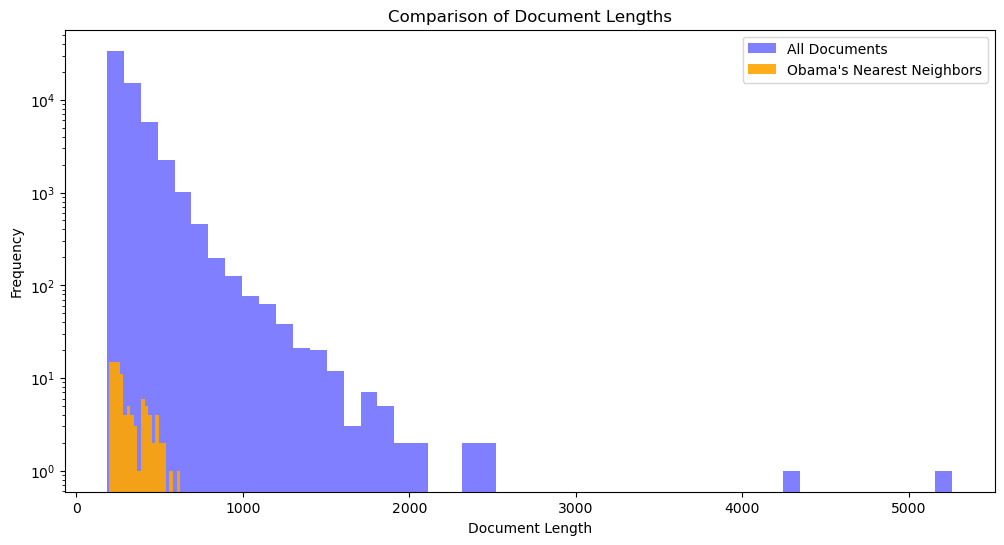

In [18]:
# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(wiki['length'], bins=50, alpha=0.5, label='All Documents', color='blue')
plt.hist(nearest_neighbors_lengths, bins=20, alpha=0.9, label="Obama's Nearest Neighbors", color='orange')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Comparison of Document Lengths')
plt.yscale('log')  # Logarithmic scale for better clarity
plt.show()


The Euclidean distance histogram shows a noticeable bias toward shorter documents among Barack Obama’s 100 nearest neighbors. This occurs because Euclidean distance is sensitive to vector magnitude, which tends to be smaller for shorter documents, leading to the clustering of lower-length texts that share overlapping terms with Obama’s article. As a result, the Euclidean approach often highlights documents that are similar in structure but not necessarily in content depth or complexity.

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

**d)** Train a new nearest neighbor model, this time with cosine distances.  Then repeat the search for Obama's 100 nearest neighbors and make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

In [19]:
from sklearn.metrics.pairwise import cosine_distances

# Compute cosine distances incrementally for Barack Obama's article
obama_cosine_distances = cosine_distances(TFIDFmatrix[obama_index], TFIDFmatrix).flatten()

# Add these distances to the DataFrame
wiki['obama_cosine_distances'] = obama_cosine_distances

# Find the 100 nearest neighbors
nearest_neighbors_cosine = wiki.nsmallest(100, 'obama_cosine_distances')

# Display the nearest neighbors
nearest_neighbors_cosine_lengths = nearest_neighbors_cosine['length']
print(nearest_neighbors_cosine_lengths)


35817    531
24478    407
38376    303
2412     210
38714    253
        ... 
25566    309
49430    276
57793    224
18752    231
16155    262
Name: length, Length: 100, dtype: int64


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

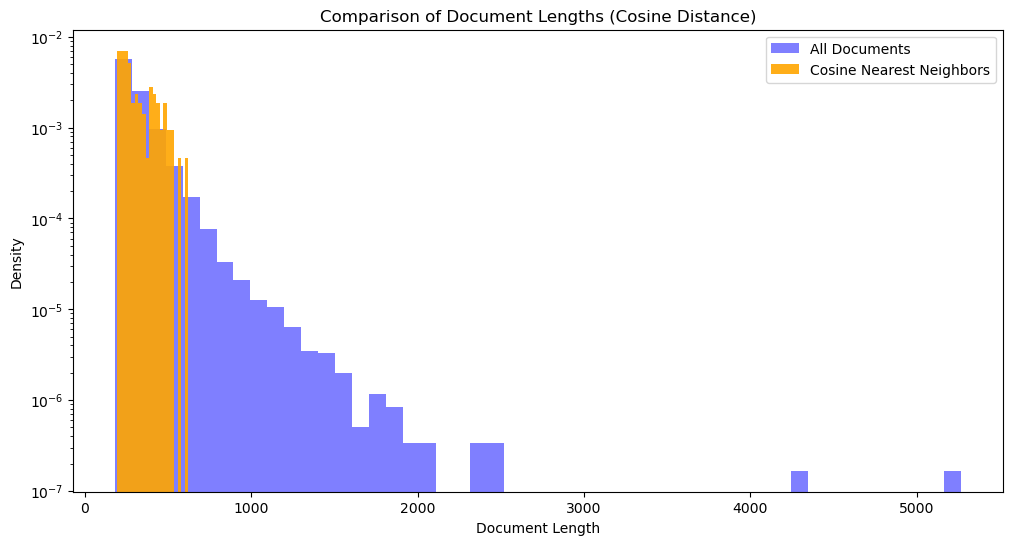

In [20]:
# Plot histogram for all documents and cosine nearest neighbors
plt.figure(figsize=(12, 6))
plt.hist(wiki['length'], bins=50, alpha=0.5, label='All Documents', color='blue', density=True)
plt.hist(nearest_neighbors_cosine_lengths, bins=20, alpha=0.9, label="Cosine Nearest Neighbors", color='orange', density=True)
plt.xlabel('Document Length')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Comparison of Document Lengths (Cosine Distance)')
plt.yscale('log')  # Logarithmic scale for better clarity
plt.show()


The cosine distance histogram displays a broader distribution of document lengths. Cosine similarity normalizes for vector magnitude, focusing purely on the angle between vectors, which allows for the identification of neighbors with similar term distributions, regardless of document length. This results in a more balanced selection of documents, reflecting a wider range of content sizes and enhancing the capture of meaningful semantic relationships.

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

## Ex. 5: Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

**a)** Transform the tweet into TF-IDF features, using the fit to the Wikipedia dataset. (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.) How similar is this tweet to Barack Obama's Wikipedia article? 

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a DataFrame for the tweet
df = pd.DataFrame({'text': ['democratic governments control law in response to popular act']})

# Transform the tweet into TF-IDF features using the pre-trained vectorizer
tweet_tfidf = vectorizer.transform(df['text'])

# Locate the TF-IDF vector for Barack Obama's article
obama_index = wiki[wiki['name'] == "Barack Obama"].index[0]
obama_tfidf = TFIDFmatrix[obama_index]

# Compute the cosine similarity between the tweet and Obama's article
similarity = cosine_similarity(tweet_tfidf, obama_tfidf)

# Display the similarity
print(f"Cosine similarity between the tweet and Barack Obama's article: {similarity[0][0]:.4f}")

Cosine similarity between the tweet and Barack Obama's article: 0.3386


Let's compare this tweet's TF-IDF vectors  to Barack Obama's Wikipedia entry.

In [22]:
obama_tf_idf

,word,tf-idf
358582,obama,52.295653
488178,the,40.004063
45084,act,35.678223
251924,in,30.028962
259239,iraq,21.747379
...,...,...
182862,equina,0.000000
182861,equiluz,0.000000
182860,equilium,0.000000
182859,equilibriums,0.000000


**b)** Now, compute the cosine distance between the Barack Obama article and this tweet:

In [23]:
from sklearn.metrics.pairwise import cosine_distances

# Compute the cosine distance between Barack Obama's TF-IDF vector and the tweet's TF-IDF vector
cosine_distance = cosine_distances(tweet_tfidf, obama_tfidf)

# Display the cosine distance
print(f"Cosine distance between the tweet and Barack Obama's article: {cosine_distance[0][0]:.4f}")

Cosine distance between the tweet and Barack Obama's article: 0.6614


Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia nearest neighbors:

In [24]:
nearest_neighbors_cosine[0:23]

,URI,name,text,BO-eucl,BO-eucl-TF-IDF,length,obama_cosine_distances
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,0.000000,0.000000,531,0.000000
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,31.336879,148.778454,407,0.540240
38376,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,42.544095,139.364493,303,0.674404
2412,<http://dbpedia.org/resource/Joe_the_Plumber>,Joe the Plumber,samuel joseph wurzelbacher wrzlbkr born decemb...,49.749372,150.462034,210,0.683807
38714,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,45.310043,140.450064,253,0.702627
53303,<http://dbpedia.org/resource/Juan_F._Vasquez>,Juan F. Vasquez,juan f vasquez born texas 1948 is a judge of t...,53.469618,150.233898,218,0.702682
4408,<http://dbpedia.org/resource/Joe_Lieberman>,Joe Lieberman,joseph isadore joe lieberman born february 24 ...,38.183766,196.040193,444,0.706613
18827,<http://dbpedia.org/resource/Henry_Waxman>,Henry Waxman,henry arnold waxman born september 12 1939 is ...,45.055521,145.288309,275,0.715553
24837,<http://dbpedia.org/resource/Leon_Panetta>,Leon Panetta,leon edward panetta born june 28 1938 is an am...,51.107729,160.285205,204,0.719558
57108,<http://dbpedia.org/resource/Hillary_Rodham_Cl...,Hillary Rodham Clinton,hillary diane rodham clinton hlri dan rdm klnt...,40.926764,167.515131,570,0.720494


With cosine distances, the tweet is "nearer" to Barack Obama than most people! If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet?
In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.